# Swarm Fundraising and Token AMM Modelling

# Table of contents

1. [Bonding curve functions](#Bonding-curve-functions)
2. [Bonding curve initialization](#Bonding-curve-initialization)
3. [Best and worst case funding scenarios](#Best-and-worst-case-funding-scenarios)
4. [Funding scenario & hatch phase walkthrough](#Funding-scenario-&-hatch-phase-walkthrough)
5. [Simulations](#Simulations)

## Dependencies

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,4)})

from model.helpers import *

# Bonding curve functions

## Connector weight / reserve ratio

$$
\begin{aligned}
CW & = \frac{R}{PS} \\
\end{aligned}
$$

Where:
$$
\begin{aligned}
CW & \equiv \text{connector weight} \equiv \text{reserve ratio} \\
R & \equiv \text{reserve} \\
P & \equiv \text{spot price} \\
S & \equiv \text{supply} \\
\end{aligned}
$$

## mint(deltaR, R, S, cw): collateral to token conversion

$$
mint(\vec{\Delta}R) = S * ((1 + \frac{\vec{\Delta}R}{R})^{cw} - 1)
$$

## withdraw(deltaS, R, S, cw): token to collateral conversion

$$
withdraw(\vec{\Delta}S) = R * (1 - (1 - \frac{\vec{\Delta}S}{S})^{\frac{1}{cw}})
$$

In [2]:
# Source
# https://storage.googleapis.com/website-bancor/2018/04/01ba8253-bancor_protocol_whitepaper_en.pdf
# https://yos.io/2018/11/10/bonding-curves/

def spot_price(R, S, cw):
    return R/(S*cw)

def mint(deltaR, R, S, cw):
    #deltaS = S*((1 + deltaR / R)**cw - 1)
    deltaS = S*((1 + deltaR / R)**cw - 1)
    if deltaS == 0:
        realized_price = spot_price(R, S + deltaS, cw)
    else:
        realized_price = deltaR/deltaS
    return deltaS, realized_price

def withdraw(deltaS, R, S, cw):
    if deltaS == S:
        deltaR = R
    else:
        #deltaR = R*((1 + deltaS / S)**(1/cw) - 1)
        deltaR = R*(1 - (1 - deltaS / S)**(1/cw))
    if deltaS == 0:
        realized_price = spot_price(R + deltaR, S, cw)
    else:
        realized_price = deltaR/deltaS
    return deltaR, realized_price

# Called in constructor by minter along with required collateral
# Supply and reserve should never reach zero, otherwise you'd get a division by zero error
def initialize_curve(Ri, Pi, cw):
    initial_reserve = Ri
    initial_supply = Ri/(Pi*cw)
    initial_price = spot_price(initial_reserve, initial_supply, cw)
    return initial_reserve, initial_supply, initial_price

# Bonding curve initialization

Suppose, we would like to issue a token with an initial supply of dev + inv to be pre-allocated to developers and investors, respectively. Investors obtain their tokens at a pre-sale price p after which the price is free-floating, subject to market forces of available supply and demand.

Further Conditions:
* If the sale of inv tokens is unsuccessful, investors are refunded in full.
* If the initial sale is successful, most of the collected funds must be available for developers, without them having to sell their tokens.
* The rest is used for funding the bonding curve contracts market making.


> ... in the initial sale phase, while x < inv, a different, constant function, f(x) = p is used and no other tokens are allowed to exist. When the sale concludes successfully (i.e. x = inv), dev tokens are allocated to developers and the final price function is activated. At this point the price should still be p to prevent discontinuities.

Source: https://gist.github.com/nagydani/d5c09c331224bfbffbcbe28b347ceb8e

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from math import isclose

In [4]:
# Initial conditions
initial_raise = 3e6
premine = 3e6
cw = 0.25
P0 = 1

In [20]:
initial_raise_widget = widgets.IntSlider(min=1e6, max=10e6, step=500e3, value=3e6)
cw_widget = widgets.FloatSlider(min=0.05, max=1, step=0.05, value=0.25)
P0_widget = widgets.FloatSlider(min=0.1, max=10, step=0.1, value=1)

def check_funding(
        initial_raise = initial_raise,
        premine = premine,
        cw = cw,
        P0 = P0,
    ):
    
    Ri = 10
    Pi = P0
    initial_reserve, initial_supply, initial_price = initialize_curve(Ri, Pi, cw)
    print(f'Initial reserve: {initial_reserve}\nInitial supply: {initial_supply}\nInitial price: {initial_price}')
    
    initial_market_cap = initial_raise + premine
    R0 = initial_market_cap * cw
    S0 = R0 / (cw * P0)
    P = spot_price(R0, S0, cw)
    
#     assert isclose(P, P0, abs_tol=10**-2)
    
    investor_supply = initial_raise / P0
    developer_supply = S0 - investor_supply

    print(f'Initial reserve R0: {millify(R0)}')
    print(f'Initial supply S0: {millify(S0)}')
    print()
    print(f'Investor supply: {millify(investor_supply)}')
    print(f'Developer supply: {millify(developer_supply)}')
    print()

    assert S0 == investor_supply + developer_supply

    # Assert mint and withdraw are accurate
    purchase_value = 1e6
    deltaS, _ = mint(purchase_value, initial_reserve, initial_supply, cw)
    deltaR, _ = withdraw(deltaS, initial_reserve + purchase_value, initial_supply + deltaS, cw)
    assert isclose(deltaR, purchase_value, abs_tol=10**-2)

    # Best case: liquid funds (not in reserve) available from investor funding
    deltaR, _realized_price = withdraw(S0, initial_reserve + R0, initial_supply + S0, cw)
    liquid_funds = initial_raise - deltaR
    print(f'Liquid funds: {millify(liquid_funds)}')
    print()

    # Worst case: developer/premine token supply used for funding, after everyone has withdrawn
    # Investors withdraw
    deltaR, realized_price = withdraw(investor_supply, initial_reserve + R0, initial_supply + S0, cw)
    remaining_reserve = R0 - deltaR
    print(f'Remaining reserve: {millify(remaining_reserve)}')
    print()

    # Developer tokens withdrawn for funding
    developer_reserve, realized_price = withdraw(developer_supply, remaining_reserve, developer_supply, cw)
    print(f'Developer reserve: {millify(developer_reserve)}')
    quoted_price = spot_price(remaining_reserve, developer_supply, cw)
    print(f'Quoted price: {millify(quoted_price)}')
    print(f'Realized price: {millify(realized_price)}')
    print(f'Slippage: {millify((realized_price - quoted_price) * 100 / quoted_price)}%')
    print()

    assert isclose(remaining_reserve, developer_reserve, abs_tol=10**-2)
    
    return initial_reserve, initial_supply, initial_price, initial_market_cap, R0, S0, P0

interact(
    check_funding,
    initial_raise=initial_raise_widget,
    premine=fixed(3e6),
    cw=cw_widget,
    P0=P0_widget
);

interactive(children=(IntSlider(value=3000000, description='initial_raise', max=10000000, min=1000000, step=50…

# Best and worst case funding scenarios

The best case is that the investor funding goal of \\$3mil is met, and the liquid funding available for the project is the difference between the investment value and the collateral required for providing bonding curve liquidity.

In the worst case, all contributors including investors withdraw their funds. This leaves the value of the developer token supply available for project funding.

From the original spec and bonding curve design, the best and worst case funding scenarios were:
* Best case: \\$2mil funding
* Worst case: \\$100k funding

In [6]:
initial_reserve, initial_supply, initial_price, initial_market_cap, R0, S0, P0 = check_funding()
print(initial_reserve, initial_supply, initial_price, initial_market_cap, R0, S0, P0)

Initial reserve: 10
Initial supply: 40.0
Initial price: 1.0
Initial reserve R0: 1.500 Million
Initial supply S0: 6.000 Million

Investor supply: 3.000 Million
Developer supply: 3.000 Million

Liquid funds: 1.500 Million

Remaining reserve: 93.743 Thousand

Developer reserve: 93.743 Thousand
Quoted price: 0.125
Realized price: 0.031
Slippage: -75.000%

10 40.0 1.0 6000000.0 1500000.0 6000000.0 1


# Funding scenario & hatch phase walkthrough

In the constructor, the contract creator is allocated an initial arbitrary supply of tokens at a certain price, and the connector weight is set.
Given the target initial raise of \\$3 mil, and the premine market cap of \\$3 mil, we can calculate the initial reserve `R0`, supply `S0`, and price `P0`.

We can use the connector weight `cw` as a design parameter. The initial price `P0` affects the initial supply scaling, but has no effect on the reserve ratios.

In [7]:
initial_raise = 3e6
premine = 3e6
cw = 0.25
P0 = 1

initial_market_cap = initial_raise + premine
R0 = initial_market_cap * cw
S0 = R0 / (cw * P0)

assert P0 == spot_price(R0, S0, cw)

---

From this, we can also calculate the investor and developer supply at the point where the fundraise is complete and the developers have been allocated their premined tokens.

In [8]:
investor_supply = initial_raise / P0
developer_supply = S0 - investor_supply

print(f'Investor supply: {millify(investor_supply)}\nDeveloper supply: {millify(developer_supply)}')

Investor supply: 3.000 Million
Developer supply: 3.000 Million


---

In the constructor, the contract creator is allocated an initial arbitrary supply of tokens at a certain price, and the connector weight is set.

In [9]:
Ri = 10
Pi = P0

initial_reserve, initial_supply, initial_price = initialize_curve(Ri, Pi, cw)
print(initial_reserve, initial_supply, initial_price)

10 40.0 1.0


---

Investors are now given the opportunity to invest in exchange for tokens at a given rate, defined by the initial connector weight we chose.

Investors buy tokens at the price `P0`, and are given tokens at the current spot price `P`.

The difference between the investment value and the amount required for the investor token reserve is used to back the \\$3 million premined token reserve. Any remaining investment collateral can be immediately used to fund the project - the liquid funds.

In [10]:
# For simplicity, two initial investment values
investment_1 = initial_raise / 2
investment_2 = initial_raise / 2

# Investors are minted tokens according to the hatch price P0
# These tokens are frozen until such stage that the hatch phase is completed
investment_1_tokens = investment_1 / P0
investment_2_tokens = investment_2 / P0

# The value of these tokens after the hatch phase, would be:
hatch_value, _ = withdraw(investment_1_tokens + investment_2_tokens, initial_reserve + R0, initial_supply + S0, cw)
print(f'Hatch value of investor supply: ${millify(hatch_value)}')

Hatch value of investor supply: $1.406 Million


---

Developers are allocated premined tokens. There can either be a vesting period for these tokens, or they could be bought at an arbitrary price, because the developer token reserve is covered by the original investment.

The developer token reserve value after the hatch phase can be calculated using the specified market cap of \\$3 million.

In [11]:
developer_reserve, _ = withdraw(developer_supply, initial_reserve + R0, initial_supply + S0, cw)
print(f'Hatch value of developer supply: ${millify(developer_reserve)}')

Hatch value of developer supply: $1.406 Million


---

In the worst case, if the entire token supply has been withdrawn less the developer token supply, we can calculate the developer token value as follows:

In [12]:
deltaR, realized_price = withdraw(investor_supply, initial_reserve + R0, initial_supply + S0, cw)

developer_reserve, realized_price = withdraw(developer_supply, initial_reserve + R0 - deltaR, initial_supply + S0 - investor_supply, cw)
print(f'Value of developer supply: ${millify(developer_reserve)}')
quoted_price = spot_price(initial_reserve + R0 - deltaR, initial_supply + S0 - investor_supply, cw)
print(f'Quoted price: {millify(quoted_price)}')
print(f'Realized price: {millify(realized_price)}')
print(f'Slippage: {millify((realized_price - quoted_price) * 100 / quoted_price)}%')

Value of developer supply: $93.753 Thousand
Quoted price: 0.125
Realized price: 0.031
Slippage: -75.000%


---

After the hatch phase is complete, the market can be opened up to users. Tokens will be minted along the bonding curve at a price dependent on the connector weight.

Theoretically, this connector weight could be changed after the hatch phase, perhaps with governance logic.

In [13]:
user_contribution = 1000 # Dai

R = initial_reserve + R0
S = initial_supply + S0

token_reward, realized_price = mint(user_contribution, R, S, cw)
quoted_price = spot_price(R, S, cw)

print(f'Token reward: {millify(token_reward)}')
print(f'Quoted price: {millify(quoted_price)}')
print(f'Realized price: {millify(realized_price)}')
print(f'Slippage: {millify((realized_price - quoted_price) * 100 / quoted_price)}%')

Token reward: 999.750
Quoted price: 1.000
Realized price: 1.000
Slippage: 0.025%


---

We can get a better idea of transaction slippage by minting and withdrawing fractional amounts of the user contribution.

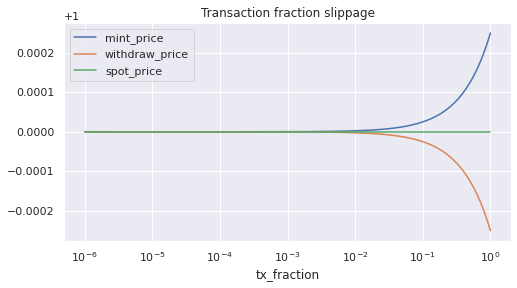

In [14]:
# Sweep the transaction fraction
TXF = np.logspace(-6, 0, num=1000)

# Realized price for withdrawing / burning .1% of tokens
withdraw_price = [withdraw(token_reward*txf, R, S, cw)[1] for txf in TXF]

# Realized price for minting .1% more collateral into the reserve
mint_price = [mint(user_contribution*txf, R, S, cw)[1] for txf in TXF]

pdf = pd.DataFrame({'tx_fraction':TXF, 'spot_price': quoted_price*np.ones(len(TXF)), 'mint_price': mint_price, 'withdraw_price': withdraw_price })
pdf.plot(title = 'Transaction fraction slippage', x = 'tx_fraction', y = ['mint_price','withdraw_price','spot_price'], logx = True)
plt.savefig('outputs/transaction-slipage.png')

# Simulations

Using the Commons Stack & BlockScience's bonding curve variation, called the "augmented bonding curve", along with the invariant relationship, we can more easily plot the reserve, supply, and price for different connector-weights.

In [15]:
def invariant(R, S, cw):
    return (S**(1/cw))/R

def reserve(S, V0, cw):
    return (S**(1/cw))/V0

def supply(R, V0, cw):
    return (V0*R)**cw

def spot_price(R, V0, cw):
    return (1/cw)*R**((1-cw))/V0**(cw)

## Bonding curve hatch phase plots

See https://github.com/BlockScience/cadCAD-Tutorials/blob/master/00-Reference-Mechanisms/01-augmented-bonding-curve/hatch_sim.ipynb

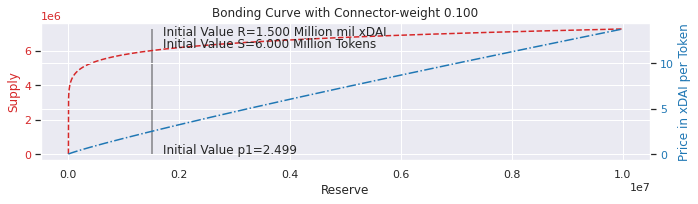

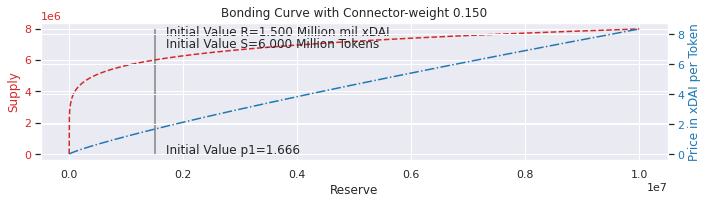

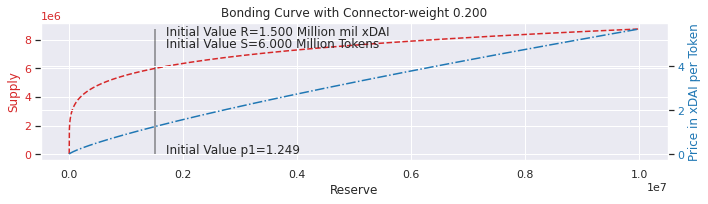

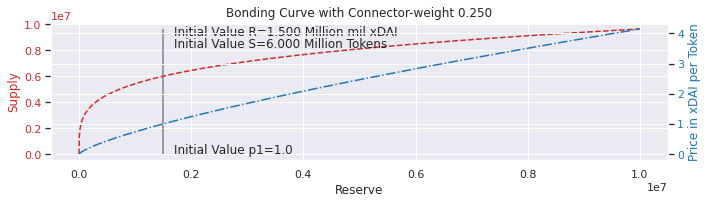

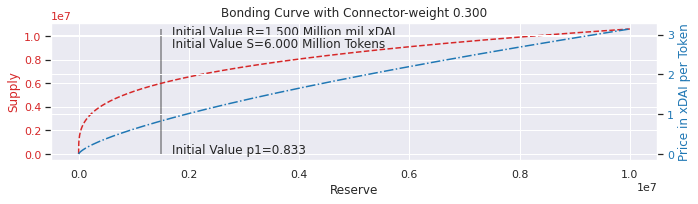

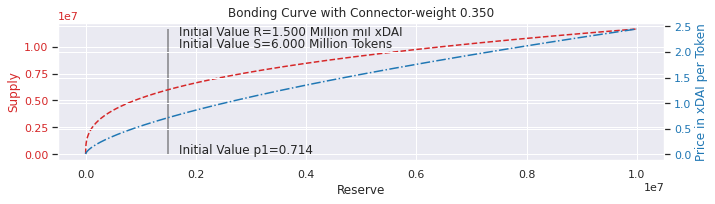

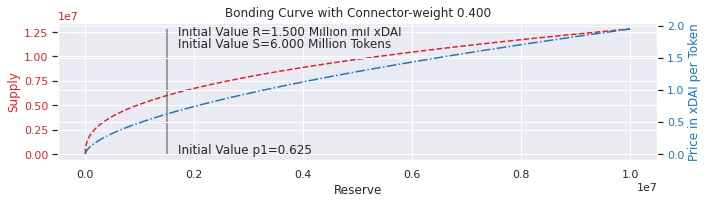

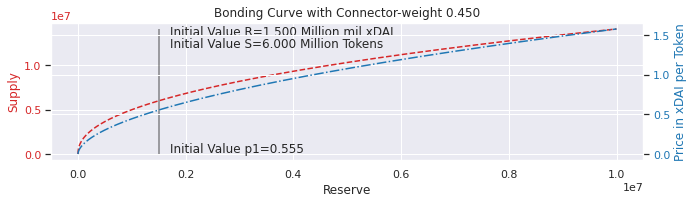

In [16]:
cw_list = [i for i in numpy.arange(0.1, 0.5, 0.05)]

for cw in cw_list:
    
    V0 = invariant(R0, S0, cw)
    
    reserve = np.arange(0, 10e6, 1e3)
    supp = np.array([supply(r, V0, cw) for r in reserve])
    price = np.array([spot_price(r, V0, cw) for r in reserve])

    fig, ax1 = plt.subplots(figsize=(10,3))

    color = 'tab:red'
    ax1.set_xlabel('Reserve')
    ax1.set_ylabel('Supply', color=color)
    ax1.plot(reserve, supp,'--', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('Price in xDAI per Token', color=color)
    ax2.plot(reserve, price,'-.', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.vlines(R0,0,supp[-1], alpha=.5)
    ax1.text(R0+.02*reserve[-1], .95*supp[-1], f'Initial Value R={millify(R0)} mil xDAI')
    ax1.text(R0+.02*reserve[-1], .85*supp[-1], f'Initial Value S={millify(S0)} Tokens')
    #ax1.hlines(S0,0,R0)

    ax2.text(R0+.02*reserve[-1], price[3], f'Initial Value p1={int(1000*spot_price(R0,V0,cw))/1000}')

    plt.title(f'Bonding Curve with Connector-weight {millify(cw)}')
    fig.tight_layout()
    plt.show()

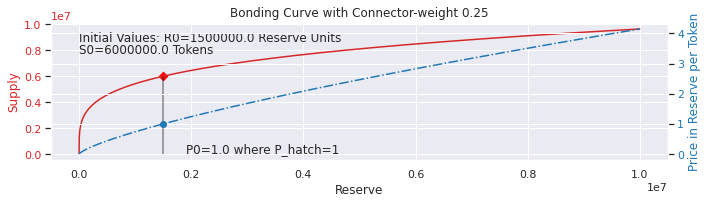

In [17]:
cw = 0.25
V0 = invariant(R0, S0, cw)

reserve = np.arange(0, 10e6, 1e3)
supp = np.array([supply(r, V0, cw) for r in reserve])
price = np.array([spot_price(r, V0, cw) for r in reserve])

fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('Reserve')
ax1.set_ylabel('Supply', color=color)
ax1.plot(reserve, supp,'-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price in Reserve per Token', color=color)
ax2.plot(reserve, price,'-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(R0,0,S0, alpha=.5)
ax1.scatter(R0,S0, color='red', marker='D')

ax1.text(-.4, .9*supp[-1], f'Initial Values: R0={int(100*R0)/100} Reserve Units')
ax1.text(-.4, .80*supp[-1], f'S0={S0} Tokens')

ax2.text(R0+.04*reserve[-1], price[25], f'P0={spot_price(R0, V0, cw)} where P_hatch={P0}')
ax2.scatter(R0,spot_price(R0, V0, cw), color=color)

plt.title(f'Bonding Curve with Connector-weight {cw}')
fig.tight_layout()
plt.savefig('outputs/bonding-curve.png')
plt.show()

## Effect of token holder withdrawing on spot-price

Creating mesh grid
Plotting figure


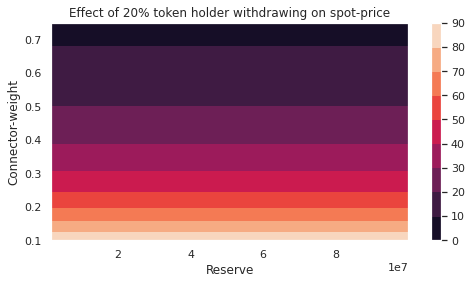

In [18]:
print("Creating mesh grid")

cw = 0.25
V0 = invariant(R0, S0, cw)

reserve = np.arange(R0, 100e6, 1e3)
cw_list = [i for i in numpy.arange(0.1, 0.8, 0.05)]

# supply = np.array([supply(r, V0, cw) for r in reserve])
# price = np.array([spot_price(r, V0, cw) for r in reserve])

X, Y = np.meshgrid(reserve, cw_list)

def valuation(reserve, cw):
    V0 = invariant(R0, S0, cw)
    supp = supply(reserve, V0, cw)
    price = spot_price(reserve, V0, cw)
    result, _ = withdraw(0.2 * supp, reserve, supp, cw)
    new_price = spot_price(reserve - result, V0, cw)
    return max(0, 100*(price - new_price)/price)

np_func = np.frompyfunc(valuation, 2, 1)

Z = np.nan_to_num(np_func(X, Y))

print("Plotting figure")

plt.contourf(X,Y,Z)
plt.colorbar()
plt.title('Effect of 20% token holder withdrawing on spot-price')
plt.xlabel('Reserve')
plt.ylabel('Connector-weight')
plt.savefig('outputs/20pct-withdraw-heatmap.png')
plt.show()

## Transaction size slippage

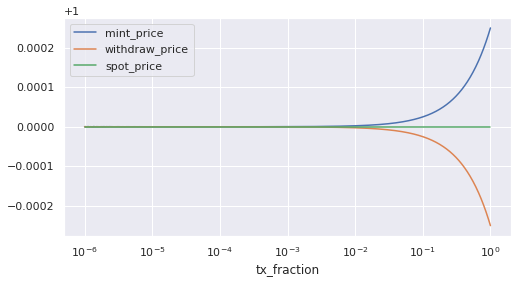

In [19]:
import pandas as pd

transaction_size = 1000

# Sweep the transaction fraction
TXF = np.logspace(-6, 0, num=1000)

# Realized price for withdrawing / burning .1% of tokens
withdraw_price = [withdraw(transaction_size*txf, R0, S0, cw)[1] for txf in TXF]

# Realized price for minting .1% more collateral into the reserve
mint_price = [mint(user_contribution*txf, R0, S0, cw)[1] for txf in TXF]

pdf = pd.DataFrame({'tx_fraction':TXF, 'spot_price': quoted_price*np.ones(len(TXF)), 'mint_price': mint_price, 'withdraw_price': withdraw_price })
pdf.plot(x = 'tx_fraction', y = ['mint_price','withdraw_price','spot_price'], logx = True)
plt.savefig('outputs/transaction-slippage-1000.png')